# Experimental Quantum Generative Adversarial Networks for Image Generation

Huang et al. describe two techniques to implement quantum generative adversarial networks on contemporary, NISQ quantum computers.  One technique (patch) optimizes for the case where the number of feature dimensions exceeds the number of dimensions in the quantum computer's state space, and another (batch) increases the amount of parallelism during training and generation.

$x$

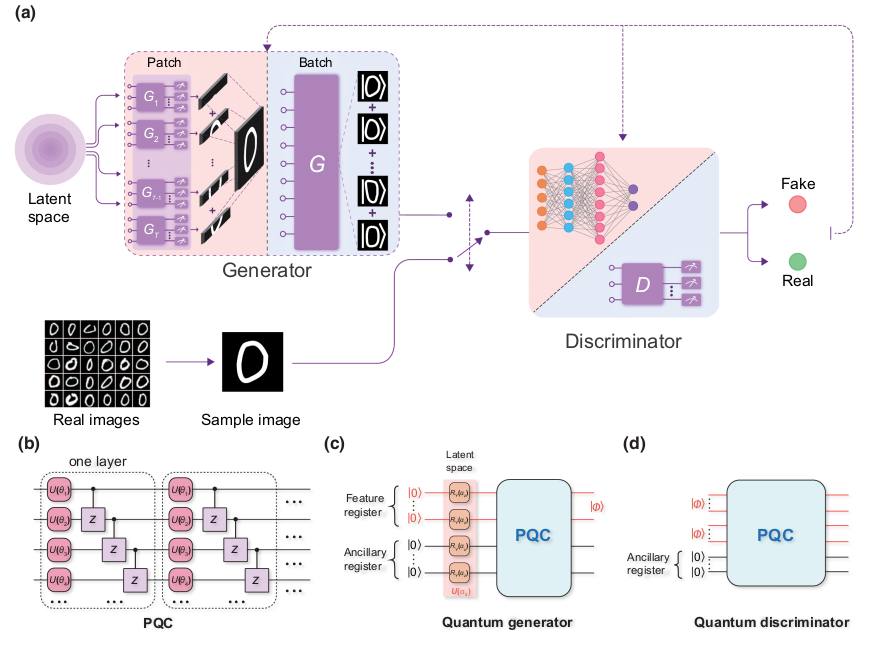

In [48]:
import pennylane as qml
import numpy as np
import torch as tr
from torch import tensor, nn, utils, optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from math import pi
import matplotlib.pyplot as plt
from rich.progress import track

torch_dev = "cpu"

## Dataset

We use the MNIST handwritten digit database to replicate the results in the paper.

In [2]:
# Filter the dataset to include on example with this label
class_filter = 0
# Resize the 28x28 MNIST digits down to this size
image_size = 8

In [3]:
data_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])
dataset = datasets.MNIST(
    'data', train=True, download=True, transform=data_transform
)
dataset_filtered = utils.data.Subset(
    dataset, np.nonzero(dataset.targets == class_filter).view(-1)
)
data_loader = utils.data.DataLoader(dataset_filtered, batch_size=1, num_workers=2)

## Patch GAN

The patch GAN setup employs a quantum generator and a classical discriminator.

[An article](https://pennylane.ai/qml/demos/tutorial_quantum_gans.html) by James Ellis for PennyLane contains an implementation of this strategy, and this code is the almost verbatim from that article.

In [17]:
qubits = 5
qubits_ancillary = 1
gen_depth = 6

patch_size = (8, 2)
assert 2**(qubits - qubits_ancillary) == patch_size[0]*patch_size[1]
assert image_size % patch_size[0] == 0 and image_size % patch_size[1] == 0
patch_num = (image_size // patch_size[0], image_size // patch_size[1])

train_iters = 500

gen_lr = 0.3
dis_lr = 0.01

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_size*image_size, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.stack(x)

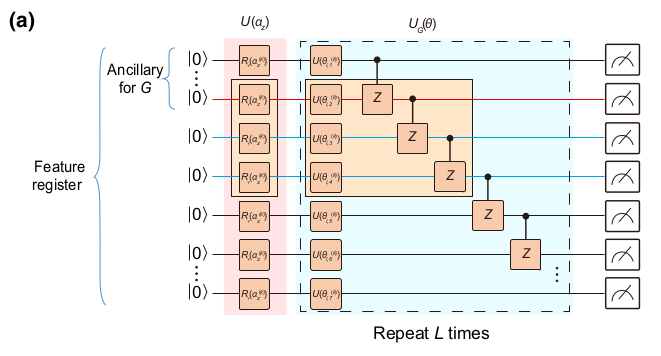

In [6]:
quantum_dev = qml.device('lightning.qubit', wires=qubits)
@qml.qnode(quantum_dev, interface='torch', diff_method='parameter-shift')
def gen_circuit(noise, weights):
    qml.AngleEmbedding(noise, wires=list(range(qubits)), rotation='Y')
    qml.BasicEntanglerLayers(weights, wires=list(range(qubits)), rotation=qml.RY)
    return qml.probs(wires=list(range(qubits)))

In [7]:
print(qml.draw(gen_circuit)(tr.rand(qubits), tr.rand(gen_depth, qubits)))

0: ─╭AngleEmbedding(M0)─╭BasicEntanglerLayers(M1)─┤ ╭Probs
1: ─├AngleEmbedding(M0)─├BasicEntanglerLayers(M1)─┤ ├Probs
2: ─├AngleEmbedding(M0)─├BasicEntanglerLayers(M1)─┤ ├Probs
3: ─├AngleEmbedding(M0)─├BasicEntanglerLayers(M1)─┤ ├Probs
4: ─╰AngleEmbedding(M0)─╰BasicEntanglerLayers(M1)─┤ ╰Probs


In [8]:
def partial_measure(noise, weights):
    probs = gen_circuit(noise, weights)
    probs_given_0 = probs[:2**(qubits-qubits_ancillary)] / tr.sum(probs)
    probs_out = probs_given_0 / tr.max(probs_given_0)
    return probs_out.float()

In [9]:
class PatchGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.ParameterList([
            nn.ParameterList([
                nn.Parameter(tr.rand(gen_depth, qubits), requires_grad=True)
                for _ in range(patch_num[1])
            ])
            for _ in range(patch_num[0])
        ])
        
    def forward(self, noise):
        batch = tr.zeros((0, image_size, image_size), device=torch_dev)
        for x in noise:
            out = tr.zeros((0, image_size), device=torch_dev)
            for wr in self.weights:
                row = tr.zeros((patch_size[0], 0), device=torch_dev)
                for w in wr:
                    y = partial_measure(x, w).reshape(patch_size)
                    row = tr.cat((row, y), dim=1)
                out = tr.cat((out, row), dim=0)
            batch = tr.cat((batch, out.reshape(1, image_size, image_size)), dim=0)
        return batch

In [10]:
gen_model = PatchGenerator().to(torch_dev)
dis_model = Discriminator().to(torch_dev)

loss_fn = nn.BCELoss()
gen_optimizer = optim.SGD(gen_model.parameters(), lr=gen_lr)
dis_optimizer = optim.SGD(dis_model.parameters(), lr=dis_lr)

In [31]:
for i, (real_data, _) in zip(track(range(train_iters)), data_loader):
    real_data =  real_data.to(torch_dev)
    b_size = real_data.size(0)
    real_labels = tr.full((b_size,), 1.0, dtype=tr.float, device=torch_dev)
    fake_labels = tr.full((b_size,), 0.0, dtype=tr.float, device=torch_dev)
    
    noise = tr.rand(b_size, qubits, device=torch_dev) * pi/2
    fake_data = gen_model(noise)

    dis_model.zero_grad()
    out_real = dis_model(real_data).view(-1)
    out_fake = dis_model(fake_data.detach()).view(-1)
    dis_err_real = loss_fn(out_real, real_labels)
    dis_err_fake = loss_fn(out_fake, fake_labels)
    dis_err_real.backward()
    dis_err_fake.backward()
    dis_err = dis_err_real + dis_err_fake
    dis_optimizer.step()

    gen_model.zero_grad()
    out_fake = dis_model(fake_data).view(-1)
    gen_err = loss_fn(out_fake, real_labels)
    gen_err.backward()
    gen_optimizer.step()
    
    if i % 10 == 0:
        print(f'gen: {gen_err:5.4f} dis: {dis_err:5.4f}')

Output()

gen: 0.6599 dis: 1.4557

gen: 0.5884 dis: 1.3362

gen: 0.7242 dis: 1.2772

gen: 0.6859 dis: 1.4373

gen: 0.7719 dis: 1.1899

gen: 0.6744 dis: 1.4910

gen: 0.8975 dis: 1.2553

gen: 0.8260 dis: 1.2003

gen: 0.9000 dis: 1.0501

gen: 0.8478 dis: 1.4287

gen: 0.7216 dis: 1.2924

gen: 0.6504 dis: 1.2803

gen: 0.6741 dis: 1.4980

gen: 0.9001 dis: 1.0316

gen: 0.9385 dis: 1.4504

gen: 1.0055 dis: 0.9205

gen: 1.0039 dis: 1.0444

gen: 1.1713 dis: 0.8973

gen: 1.3373 dis: 0.8875

gen: 1.1621 dis: 0.8082

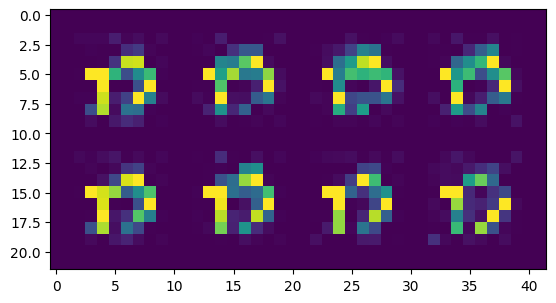

In [58]:
noise = tr.rand(8, qubits, device=torch_dev) * pi/2
plt.imshow(vutils.make_grid(gen_model(noise).cpu().detach().reshape(8,1,8,8), 
                            nrow=4)[0])

## Batch GAN

In [16]:
# qubits = 8
# qubits_index = 2
# qubits_gen_ancillary = 1
# qubits_dis_ancillary = 1

# gen_depth = 6
# dis_depth = 4

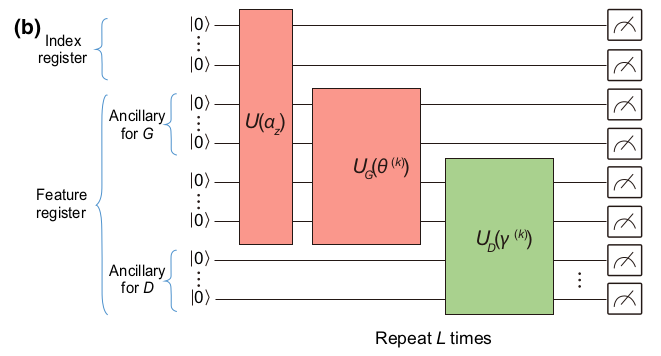

In [14]:
# quantum_dev = qml.device('lightning.qubit', wires=qubits)
# qubits_feature = qubits - qubits_index - qubits_gen_ancillary - qubits_dis_ancillary

# @qml.qnode(quantum_dev, interface='torch', diff_method='parameter-shift')
# def gen_circuit(noise, weights):
#     # U(a_z)
#     # Embed the latent space on the qubits for the index register
#     # and the generator, but not the discriminator ancillary bits.
#     for i in range(qubits - qubits_dis_ancillary):
#         qml.RY(noise[i], wires=i)
#     for i in range(gen_depth):
#         for j in range(qubits_index, qubits_index+qubits_feature):
#         for j in range(qubits_index, qubits_index+qubits_feature-1):
#             qml.CZ(wires=[j,j+1])
#     for i in range(dis_depth):
#         for j in range(qubits_index+qubits_gen_ancillary, qubits-1):
#             qml.CZ(wires=[j,j+1])
#     return qml.probs()